# Understanding the Impact of Image Quality and Distance of Objects to Object Detection Performance

***A reproduction*** 

## Downscale Data

Folder expansion: Some datasets come with multiple subfolders not needed for the purposes of our reproduction study. Example:

```
img
|_dir1 
    |_img1.png
    |_img2.png
    |_img3.png
|_dir2
    |_img1.png
    |_img2.png
    |_img3.png
|_dir3
(...)
```

In [ ]:
from data_processing.expand_folders import expand_folders
expand_folders("../datasets/ECP2dot5D_day_labels_val/ECP2dot5D/day/labels/val")

### Spatial and Amplitudinal Resolution Downsampling


Spatial - 1.42x Downsampling

In [ ]:
from data_processing.expand_dataset import expand_dataset

INPUT_IMAGE_DIR = "../datasets/ECP/day/img/val"
INPUT_LABEL_DIR = "../datasets/ECP2dot5D_day_labels_val/ECP2dot5D/day/labels/val"
DATASET_OUTPUT_DIR = "../datasets/quick_test_new_1"
label_values_to_scale = ["imageheight", "imagewidth", "x0", "y0", "x1", "y1"]
OUTPUT_IMG_DIR = f"{DATASET_OUTPUT_DIR}/img"
OUTPUT_LABEL_DIR = f"{DATASET_OUTPUT_DIR}/labels"

expand_dataset(
    input_dir=INPUT_IMAGE_DIR,
    label_dir=INPUT_LABEL_DIR,
    label_values_to_scale=label_values_to_scale,
    output_img_dir=OUTPUT_IMG_DIR,
    output_label_dir=OUTPUT_LABEL_DIR,
    expansion="spatial",
    scale_factors=[0.01], 
    qp_values=[],
    subsample_spatial=False,
    subsample_amplitudinal=False,
)

Amplitudinal Downsampling

In [ ]:
from data_processing.expand_dataset import expand_dataset

INPUT_IMAGE_DIR = "../datasets/ECP/day/img/val"
INPUT_LABEL_DIR = "../datasets/ECP2dot5D_day_labels_val/ECP2dot5D/day/labels/val"
DATASET_OUTPUT_DIR = "../datasets/eurocity_original_amplitudinally_compressed"
label_values_to_scale = ["imageheight", "imagewidth", "x0", "y0", "x1", "y1"]
OUTPUT_IMG_DIR = f"{DATASET_OUTPUT_DIR}/img"
OUTPUT_LABEL_DIR = f"{DATASET_OUTPUT_DIR}/labels"
COMPRESSION_METADATA_DIR = f"{DATASET_OUTPUT_DIR}/metadata"

qp_values = [16, 24, 34, 38, 46] #values from paper

expand_dataset(
    input_dir=INPUT_IMAGE_DIR,
    label_dir=INPUT_LABEL_DIR,
    label_values_to_scale=label_values_to_scale,
    scale_factors=[],
    output_img_dir=OUTPUT_IMG_DIR,
    output_label_dir=OUTPUT_LABEL_DIR,
    metadata_dir=COMPRESSION_METADATA_DIR,
    qp_values=qp_values, #values from paper
    expansion = "amplitudinal"
)

Mixed Downsampling - Combined Set of both

In [7]:
from data_processing.expand_dataset import expand_dataset

# INPUT_IMAGE_DIR = "../datasets/ECP/day/img/val"
INPUT_IMAGE_DIR = "/Volumes/NEW VOLUME/ECP/day/img/val"
# INPUT_LABEL_DIR = "../datasets/ECP2dot5D_day_labels_val/ECP2dot5D/day/labels/val"
INPUT_LABEL_DIR = "/Volumes/NEW VOLUME/ECP2dot5D_day_labels_val/ECP2dot5D/day/labels/val"
DATASET_OUTPUT_DIR = "datasets/quick_test_new_2"
label_values_to_scale = ["imageheight", "imagewidth", "x0", "y0", "x1", "y1"]
OUTPUT_IMG_DIR = f"{DATASET_OUTPUT_DIR}/img"
OUTPUT_LABEL_DIR = f"{DATASET_OUTPUT_DIR}/labels"
COMPRESSION_METADATA_DIR = f"{DATASET_OUTPUT_DIR}/metadata"
qp_values = [16, 24, 34, 38, 46] #values from paper

expand_dataset(
    input_dir=INPUT_IMAGE_DIR,
    label_dir=INPUT_LABEL_DIR,
    label_values_to_scale=label_values_to_scale,
    output_img_dir=OUTPUT_IMG_DIR,
    output_label_dir=OUTPUT_LABEL_DIR,
    metadata_dir=COMPRESSION_METADATA_DIR,
    scale_factors=[1, 720.0/1024, 854.0/ 1920], #values from paper
    qp_values=qp_values, #values from paper
    expansion="mixed", 
    subsample_spatial=True,
    subsample_amplitudinal=False,
    num_images=100
)

Starting Processing mixed (spatial & amplitudinal) downsampling with 7 parallel processes...


Processing mixed (spatial & amplitudinal) downsampling: 100%|██████████| 495/495 [06:14<00:00,  1.32it/s]

All images expanded and saved to /Users/lauriwarsen/Documents/code-projects/frmdl-object-detection-distance-resolution/datasets/quick_test_new_2/img and /Users/lauriwarsen/Documents/code-projects/frmdl-object-detection-distance-resolution/datasets/quick_test_new_2/labels


### Convert to YOLO format

In [1]:
from datasets.to_yolo_format import to_yolo_format

labels_dir = "datasets/quick_test_new_2/labels"  # YOLO output
images_dir = "datasets/quick_test_new_2/img"  # Images directory
dataset_root = "datasets/quick_test_new_2"          # Root directory
split = 0.8


to_yolo_format(
    labels_dir=labels_dir,
    images_dir=images_dir,
    dataset_root=dataset_root,
    split=split,
)

Converting JSON annotations to YOLO format...
Labels directory: datasets/quick_test_new_2/labels
Images directory: datasets/quick_test_new_2/img
Dataset root: datasets/quick_test_new_2


val progress: 100%|██████████| 99/99 [00:00<00:00, 1449.38it/s]

✅ Conversion complete. `data.yaml` written.


## Train/Load Model

#### Train

In [ ]:
import sys
import os
import torch
import argparse
from pathlib import Path
yolov5_dir = os.path.abspath('yolov5')
if yolov5_dir not in sys.path:
    sys.path.append(yolov5_dir)
from yolov5.train import main, Callbacks
device = 'cuda' if torch.cuda.is_available() else 'cpu'
cfg = "ra_yolo5l.yaml"  
average_image_size = 740 # Calculate average image size from dataset
opt = argparse.Namespace(
    weights='yolov5l.pt',  # Model weights
    cfg=cfg,  # Empty to use weights' default config
    data=os.path.abspath('../datasets/quick_test_new_1/data.yaml'),  # Absolute path to dataset
    hyp=os.path.join(yolov5_dir, 'data/hyps/hyp.scratch-low.yaml'),  # Hyperparameters
    epochs=1,
    batch_size=1,
    imgsz=average_image_size,  # Input image size
    rect=False,
    resume=False,
    nosave=False,
    noval=False,
    noautoanchor=False,
    noplots=False,
    evolve=None,
    evolve_population=os.path.join(yolov5_dir, 'data/hyps'),
    resume_evolve=None,
    bucket='',
    cache=None,
    image_weights=False,
    device=device,
    multi_scale=False,
    single_cls=False,
    optimizer='SGD',
    sync_bn=False,
    workers=8,
    project=os.path.join(yolov5_dir, 'runs/train'),
    name='exp',
    exist_ok=True,
    quad=False,
    cos_lr=False,
    label_smoothing=0.0,
    patience=100,
    freeze=[0],  
    save_period=-1,
    seed=0,
    local_rank=-1,
    ra_yolo=True,
    entity=None,
    upload_dataset=False,
    bbox_interval=-1,
    artifact_alias='latest',
    ndjson_console=False,
    ndjson_file=False
)

main(opt, callbacks=Callbacks())

#### Extract results

In [4]:
import torch 
from yolov5.val import run as yolov5_run_val

data = 'datasets/quick_test_new_2/data.yaml'  # Path to your dataset YAML file
weights = 'best.pt'      # Path to your model weights file
batch_size = 1             # Batch size for validation           # Image size for inference
device = 'cuda' if torch.cuda.is_available() else 'cpu'  # Automatically select device
device = 'mps' if torch.mps.is_available() else 'cpu'  # Automatically select device
confidence_threshold = 0.1
iou_threshold = 0.6
average_image_size = 740 # Calculate average image size from dataset

# Run the validation
results, maps, times = yolov5_run_val(
    data=data,                      # Dataset configuration
    imgsz=average_image_size,       # Image size for inference
    conf_thres=confidence_threshold,# confidence threshold
    iou_thres=iou_threshold,        # NMS IoU threshold
    weights=weights,                # Model weights
    batch_size=batch_size,          # Batch size
    device=device,                  # Device to run on
    task='val',                     # Task type: validation
    save_txt=True,                  # Don’t save results to text files
    save_json=True,                 # Don’t save results to JSON
    plots=True,                     # Generate plots (saved to runs/val/)
)

# Extract metrics from r
mp, mr, map50, map, box_loss, obj_loss, cls_loss = results  # Mean Precision, Mean Recall, mAP@0.5, mAP@0.5:0.95
print(f'Mean Precision: {mp:.4f}')
print(f'Mean Recall: {mr:.4f}')
print(f'mAP@0.5: {map50:.4f}')
print(f'mAP@0.5:0.95: {map:.4f}')

YOLOv5 🚀 2025-6-3 Python-3.10.6 torch-2.7.1 MPS

Fusing layers... 
ra_yolo5l summary: 400 layers, 176130586 parameters, 0 gradients, 102.7 GFLOPs
WARNING ⚠️ --img-size 740 must be multiple of max stride 64, updating to 768
val: Scanning /Users/lauriwarsen/Documents/code-projects/frmdl-object-detection-distance-resolution/datasets/quick_test_new_2/img/val.cache... 54 images, 0 backgrounds, 0 corrupt: 100%|██████████| 54/54 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 54/54 [00:14<00:00,  3.69it/s]
                   all         54        354      0.624      0.314      0.488      0.174
Speed: 1.7ms pre-process, 130.3ms inference, 1.9ms NMS per image at shape (1, 3, 768, 768)

Evaluating pycocotools mAP... saving yolov5/runs/val/exp/best_predictions.json...
pycocotools unable to run: [Errno 2] No such file or directory: '/Users/lauriwarsen/Documents/code-projects/frmdl-object-detection-distance-resolution/yolov

loading annotations into memory...
Mean Precision: 0.6236
Mean Recall: 0.3136
mAP@0.5: 0.4878
mAP@0.5:0.95: 0.1739


In [2]:
from data_processing.extract_model_predictions import extract_predictions_from_run

predictions, labels = extract_predictions_from_run(json_path="yolov5/runs/val/exp/best_predictions.json", label_dir="datasets/quick_test_new_2/labels")

In [3]:
from data_processing.extract_model_predictions import create_predictions_dataframe

df = create_predictions_dataframe(predictions, labels, "datasets/quick_test_new_2/metadata", iou_threshold=0.5)

# Get accuracy per 

100%|██████████| 50/50 [00:00<00:00, 608.94it/s]


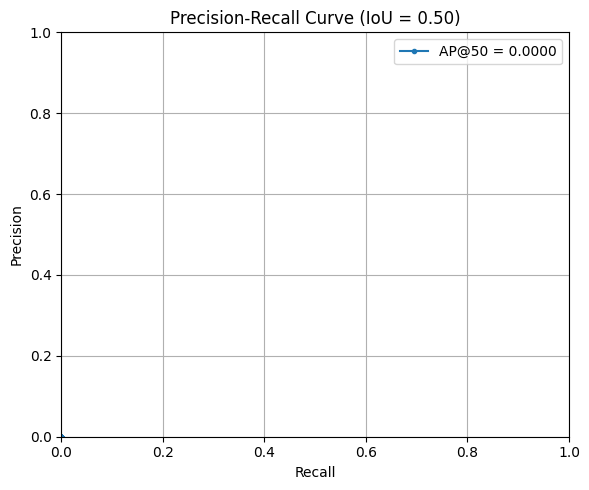

0.0

In [8]:
from utils.extract_metrics import compute_map50

map50 = compute_map50(df, plot=True)
map50

## Visualizing Results

#### Reproducing figures from the paper

#### Figure 5

In [ ]:
from visualization.xy_lineplot import basic_lineplot, multi_lineplot

data_dict = {
    "EuroCity Normal Res": ([0, 1, 2, 3, 4, 5], [0, 1, 4, 9, 16, 25]),
    "EuroCity 1.42 ": ([0, 1, 2, 6, 8, 9], [0, 1, 5, 10, 16, 27]),
    "Eurocity 1.87": ([0, 2, 3, 5, 7, 9], [0, 1, 2, 3, 12, 20]), 
}
## Figure 5 in the paper 
multi_lineplot(data_dict, xlabel="Megabytes/Image", ylabel="map@50 - All Category")

import pandas as pd
from collections import defaultdict

# Step 1: Group by both 'spatial_res' and 'amplitudal_res'
grouped = df.groupby(['spatial_res', 'amplitudal_res'])

# Step 2: Compute mean megabytes and mAP@50 per group
plot_data = defaultdict(lambda: ([], []))  # spatial_res -> (x_list, y_list)

for (spatial_res, amplitudal_res), group in grouped:
    
    print(f"Processing spatial_res: {spatial_res}, amplitudal_res: {amplitudal_res}")
    map50 = compute_map50(group, plot=False)  # Compute mAP@50 for the group
    megabytes = group['image_size_mb'].mean()
    plot_data["Eurocity: Scaled X", spatial_res][0].append(megabytes)
    plot_data["Eurocity: Scaled X", spatial_res][1].append(map50)

# Step 3: Sort each line’s data by megabytes to ensure correct plotting
for spatial_res in plot_data:
    megabytes, map_scores = plot_data[spatial_res]
    sorted_pairs = sorted(zip(megabytes, map_scores))
    x_sorted, y_sorted = zip(*sorted_pairs)
    plot_data[spatial_res] = (list(x_sorted), list(y_sorted))

multi_lineplot(
    data_dict=plot_data,
    xlabel="Megabytes/Image",
    ylabel="mAP@50 - All Category"
)

In [ ]:
from visualization.xy_lineplot import basic_lineplot, multi_lineplot

data_dict = {
    "EuroCity Original": ([0, 1, 2, 3, 4, 5], [25, 16, 10, 7, 3, 1]),
    "EuroCity 1.42 -> Finetuned Model": ([0, 1, 2, 6, 8, 9], [24, 13, 10, 5, 1, 0]),
}
## Figure 5 in the paper 
multi_lineplot(data_dict, xlabel="Distance(m)", ylabel="Recall-Pedestrian")